In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

### Input

In [2]:
# Define input paths
path_demographics: Path = Path(
    "../../../data/processed/adni/demographics.csv"
).resolve()
path_converters: Path = Path("../../../data/processed/adni/converters.csv").resolve()
path_lipo: Path = Path("../../../data/processed/adni/lipoprotein.csv").resolve()
path_lipo_dict: Path = Path(
    "../../../data/processed/adni/lipoprotein_dict.csv"
).resolve()

In [3]:
# Read files
df_demographics: pd.DataFrame = pd.read_csv(path_demographics).convert_dtypes()
df_converters: pd.DataFrame = pd.read_csv(path_converters).convert_dtypes()
df_lipo: pd.DataFrame = pd.read_csv(path_lipo).convert_dtypes()
df_lipo_dict: pd.DataFrame = pd.read_csv(path_lipo_dict).convert_dtypes()

### Process

In [4]:
# Join dataframes
df_raw: pd.DataFrame = df_demographics.merge(
    df_converters.set_index("RID"), on="RID", how="inner"
).join(df_lipo.set_index("RID"), on="RID", how="inner")

In [5]:
# Sum non-small HDL measures
df_raw["L_HDL_FC"] = df_raw["M_HDL_FC"] + df_raw["L_HDL_FC"] + df_raw["XL_HDL_FC"]
df_raw["L_HDL_CE"] = df_raw["M_HDL_CE"] + df_raw["L_HDL_CE"] + df_raw["XL_HDL_CE"]
df_raw["L_HDL_C"] = df_raw["M_HDL_C"] + df_raw["L_HDL_C"] + df_raw["XL_HDL_C"]
df_raw["ratio"] = df_raw["L_HDL_FC"] / df_raw["L_HDL_CE"]

In [6]:
# Define the predictor variable and tertile it
predictor: str = "ratio"
level_order: list[str] = ["low", "mid", "high"]
df_raw["level"] = pd.cut(
    df_raw[predictor],
    bins=[
        0,
        df_raw[predictor].quantile(1 / 3),
        df_raw[predictor].quantile(2 / 3),
        np.inf,
    ],
    labels=level_order,
)

In [7]:
# Subset to include only CN or MCI participants
df_raw: pd.DataFrame = df_raw.loc[df_raw["cog"].isin([0])].reset_index(drop=True)

### Available follow-up

In [8]:
# Instantiate follow-up timestamps
timestamps: np.ndarray = np.arange(0, 12 * 13, 12)
available_followup = pd.DataFrame(columns=timestamps, index=df_raw["RID"])

In [9]:
# For each participant, check if follow-up is available at each timestamp
for participant, max_visit in zip(df_raw["RID"], df_raw["visit_month"]):
    available_followup.loc[participant] = (max_visit >= timestamps).astype(bool)

In [10]:
# Add level to available follow-up
available_followup["level"] = df_raw.set_index("RID")["level"]

In [11]:
# Display number of available follow-up visits per level
df_followup: pd.DataFrame = (
    available_followup.groupby(by="level", observed=True)
    .sum()
    .sort_index(axis=0, ascending=False)
)

### Prepare data for analysis

In [12]:
# Subset to consider only CN or MCI participants at once
df: pd.DataFrame = df_raw[["RID", "level", "converted", "convert_month"]]

In [13]:
# Display the number and fraction of converters per level
df_count: pd.DataFrame = (
    df.groupby(by="level", observed=True)["converted"]
    .agg(["count", "sum", "mean"])
    .rename(columns={"count": "N", "sum": "N (%) converted", "mean": "fraction"})
    .sort_index(axis=0, ascending=True)
)
df_count["N (%) converted"] = (
    df_count["N (%) converted"].astype(str)
    + " ("
    + (df_count["fraction"] * 100).round(0).astype(int).astype(str)
    + ")"
)
df_count: pd.DataFrame = df_count.drop(columns=["fraction"])

### Kaplan-Meier analysis

In [14]:
# Set matplotlib parameters
plt.rcParams.update(
    {"font.size": 12, "font.family": "Arial", "figure.figsize": (10, 6)}
)

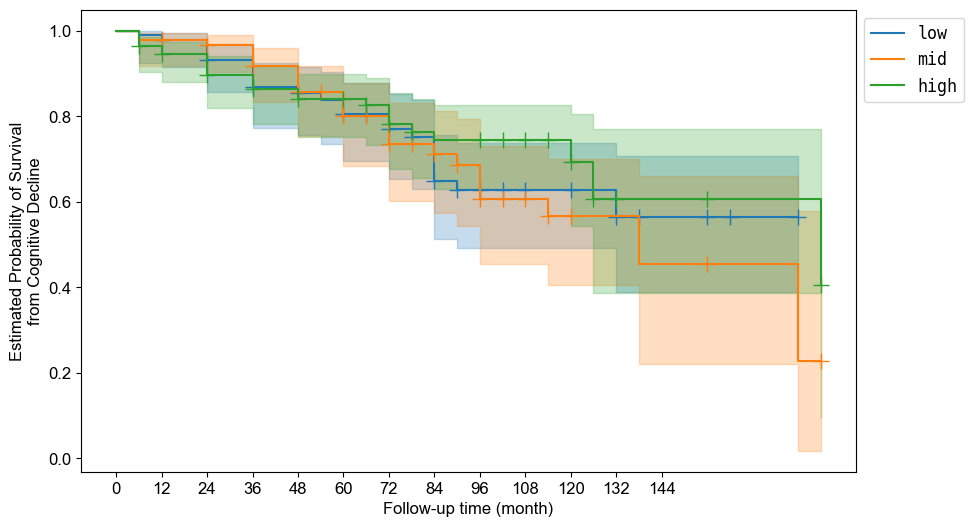

In [15]:
# Plot Kaplan-Meier curve for each level
for level in level_order:
    df_level: pd.DataFrame = df.loc[df["level"] == level].reset_index(drop=True)
    kmf = KaplanMeierFitter()
    kmf.fit(
        durations=df_level["convert_month"],
        event_observed=df_level["converted"],
        label=level,
    )
    show_ci = True
    kmf.plot(show_censors=True, ci_show=show_ci, ax=plt.gca(), label=level)
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1), prop={"family": "monospace"})
plt.xticks(range(0, 12 * 13, 12))
plt.xlabel("Follow-up time (month)")
plt.ylabel("Estimated Probability of Survival\nfrom Cognitive Decline")
plt.show()

### Log-rank comparison

In [16]:
# Subset by level
df_low: pd.DataFrame = df.loc[df["level"] == level_order[0]].reset_index(drop=True)
df_mid: pd.DataFrame = df.loc[df["level"] == level_order[1]].reset_index(drop=True)
df_high: pd.DataFrame = df.loc[df["level"] == level_order[2]].reset_index(drop=True)

In [17]:
# LogRank test comparing two levels
p_val: float = logrank_test(
    df_low["convert_month"],
    df_mid["convert_month"],
    df_low["converted"],
    df_mid["converted"],
    alpha=0.95,
).p_value
f"Low vs. Mid LogRank test p-value = {p_val:.5f}"

'Low vs. Mid LogRank test p-value = 0.75625'

### Cox regression

In [18]:
# Define comparison scope and reference group
comparison_scope: list[str] = level_order[:-1].copy()  # include all levels
reference_group: str = comparison_scope[-1]  # use the last included level as reference

In [19]:
# k-1 dummy variables are needed to represent k groups
dummy_scope: list[str] = comparison_scope.copy()
dummy_scope.remove(reference_group)

In [20]:
# Subset to compare only two levels
subset: pd.DataFrame = df.loc[df["level"].isin(comparison_scope)].reset_index(drop=True)
# Expand the levels to dummy variables
df_dummies: pd.DataFrame = pd.get_dummies(
    subset, columns=["level"], prefix="", prefix_sep="", drop_first=False, dtype=bool
).set_index("RID")

In [21]:
# Fit Cox Proportional Hazards model
cph: CoxPHFitter = CoxPHFitter(penalizer=0.1)
cph.fit(
    df_dummies[["converted", "convert_month"] + dummy_scope],
    duration_col="convert_month",
    event_col="converted",
)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 184 total observations, 134 right-censored observations>
             duration col = 'convert_month'
                event col = 'converted'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 184
number of events observed = 50
   partial log-likelihood = -224.31
         time fit was run = 2025-11-02 19:32:15 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
low       -0.06      0.94      0.24           -0.54            0.41                0.58                1.51

           cmp to     z    p  -log2(p)
covariate                             
low          0.00 -0.26 0.80      0.33
---
Concordance = 0.49
Partial AIC = 450.61
log-likelihood ratio test = 0.07 on 1 df
-log2(p) of ll-ratio test = 0.33